<p align="center">
  <img src="https://media.istockphoto.com/id/1135912032/photo/respiratory-system.jpg?s=2048x2048&w=is&k=20&c=9vBNs47uX_gaY32HKTzgO4t2I-gaYIV3LA7xZAtM1CA=" style="width:100%; max-width:900px; height:180px; object-fit:cover; border-radius:10px;"/>
</p>
<div style="text-align:center;">
  <h1 style="color:Gray; display:inline-block; margin:0;; size:2.5em">Lung Life</h1><br>
  <h1 style="color:Gray; display:inline-block; margin:0;">Aplicacion movil para diagnostico temprano de cancer pulmonar</h1>
  <p>
    <b>LungLife | Machine Learning | CRISP-DM</b><br>
    <span style="font-size:1.1em;">Análisis y predicción de la salud pulmonar utilizando machine learning.</span>
  </p>
</div>

# FASE 3: Preparacion de Datos (CRISP-DM)

## Proposito de la Fase de Preparacion de Datos

En esta tercera fase del proceso CRISP-DM, nos enfocamos en preparar y transformar los datos para que sean adecuados para el modelado. Tras completar el Analisis Exploratorio (EDA) de nuestro dataset de **300,002 registros**, el objetivo es pasar de datos brutos a tres datasets finales (train/val/test) listos para entrenar modelos de clasificacion supervisada que predigan el `Stage_of_Cancer`.

### Objetivos de esta Fase

1. **Limpieza y Tratamiento:** Manejo de valores faltantes e inconsistencias logicas
2. **Feature Engineering:** Creacion de variables derivadas clinicamente relevantes
3. **Codificacion y Escalamiento:** Transformacion de variables para ML
4. **Balanceo de Clases:** Aplicacion de SMOTE solo en entrenamiento
5. **Particion Estratificada:** Division 70/15/15 preservando distribucion del target

### Principios Clave

- **Reproducibilidad:** Todo el procesamiento debe ser replicable
- **Prevencion de Data Leakage:** Ajustar transformadores solo en train
- **Produccion:** Guardar pipelines para uso en Backend Node.js

In [1]:
# =============================================================================
# CONFIGURACION E IMPORTACIONES
# =============================================================================

# Instalar dependencias necesarias
%pip install scikit-learn imbalanced-learn -q

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

# Librerias del sistema
import sys
import os
from pathlib import Path

# Librerias de datos
import pandas as pd
import numpy as np

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Balanceo de clases
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    print("[OK] imbalanced-learn instalado correctamente")
except ImportError:
    print("[!] Instalando imbalanced-learn...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn", "-q"])
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    print("[OK] imbalanced-learn instalado correctamente")

# Persistencia de modelos
import joblib
import pickle
import json

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("=" * 60)
print("CONFIGURACION COMPLETADA - DATA PREPARATION")
print("=" * 60)
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: Disponible")

Note: you may need to restart the kernel to use updated packages.
[OK] imbalanced-learn instalado correctamente
CONFIGURACION COMPLETADA - DATA PREPARATION
Pandas: 3.0.0
NumPy: 2.4.1
Scikit-learn: Disponible


In [2]:
# =============================================================================
# CARGA DE DATOS
# =============================================================================

# Definir rutas
DATA_RAW = Path('../data/raw/lung-cancer-structured-clinical-dataset/lung_cancer_data.csv')
DATA_PROCESSED = Path('../data/processed')
MODELS_DIR = Path('../models')

# Crear directorios si no existen
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Cargar dataset
df = pd.read_csv(DATA_RAW)

print("=" * 60)
print("DATASET CARGADO EXITOSAMENTE")
print("=" * 60)
print(f"Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")
print(f"Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET CARGADO EXITOSAMENTE
Dimensiones: 300,000 filas x 30 columnas
Memoria: 199.51 MB


In [3]:
# =============================================================================
# RESUMEN INICIAL DEL DATASET
# =============================================================================

print("=" * 60)
print("RESUMEN INICIAL - ANTES DE PREPARACION")
print("=" * 60)

# Tipos de datos
print("\n[INFO] TIPOS DE DATOS:")
print(df.dtypes.value_counts())

# Valores faltantes
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Faltantes': missing[missing > 0],
    'Porcentaje': missing_pct[missing > 0]
}).round(2)

if len(missing_df) > 0:
    print("\n[!] VALORES FALTANTES DETECTADOS:")
    display(missing_df)
else:
    print("\n[OK] No hay valores faltantes")

# Duplicados
duplicados = df.duplicated().sum()
print(f"\n[INFO] REGISTROS DUPLICADOS: {duplicados:,} ({duplicados/len(df)*100:.2f}%)")

# Distribucion del target
print("\n[TARGET] DISTRIBUCION DE Stage_of_Cancer:")
target_dist = df['Stage_of_Cancer'].value_counts()
for stage, count in target_dist.items():
    pct = count / len(df) * 100
    print(f"   {stage}: {count:,} ({pct:.1f}%)")

RESUMEN INICIAL - ANTES DE PREPARACION

[INFO] TIPOS DE DATOS:
str        11
int64       8
bool        8
float64     3
Name: count, dtype: int64

[!] VALORES FALTANTES DETECTADOS:


,Faltantes,Porcentaje
Comorbidities,90376,30.13



[INFO] REGISTROS DUPLICADOS: 0 (0.00%)

[TARGET] DISTRIBUCION DE Stage_of_Cancer:
   III: 89,660 (29.9%)
   II: 75,190 (25.1%)
   I: 74,960 (25.0%)
   IV: 60,190 (20.1%)


---

## 1. Plan de Preparacion de Datos

### 1.1 Estructura del Pipeline

| Paso | Actividad | Descripcion | Entregables |
|------|-----------|-------------|-------------|
| 1 | Limpieza de datos | Tratamiento de missing values, eliminacion de duplicados | Dataset limpio |
| 2 | Feature Engineering | Creacion de features derivadas (pack_years_normalized, risk_score_composite) | Variables nuevas |
| 3 | Codificacion de variables | One-Hot Encoding para categoricas, normalizacion de numericas | Transformadores sklearn |
| 4 | Particion de datos | Division 70% / 15% / 15% estratificado | 3 datasets separados |
| 5 | Balanceo de clases | SMOTE solo en conjunto de entrenamiento | Dataset train balanceado |
| 6 | Persistencia | Guardar pipelines y datasets | Archivos .joblib y .csv |

### 1.2 Variables Nuevas a Crear

| Variable | Formula | Proposito Clinico |
|----------|---------|-------------------|
| `Cancer_Stage_Binary` | Early (I-II) = 0, Advanced (III-IV) = 1 | Target binario para clasificacion |
| `Pack_Years_Normalized` | Pack_Years / max(Pack_Years) | Exposicion tabaquica normalizada [0-1] |
| `Age_Group` | Bins: 18-40, 41-60, 61+ | Estratificacion por grupos etarios |
| `Risk_Score_Composite` | Combinacion ponderada de factores de riesgo | Score de riesgo integrado |
| `Smoking_Risk_Level` | Basado en Pack_Years + Years_Smoked | Nivel de riesgo por tabaquismo |
| `Environmental_Risk` | AQI + Exposure_to_Toxins | Riesgo ambiental combinado |
| `Symptom_Count` | Suma de sintomas presentes | Carga sintomatica total |

---

## 2. Limpieza de Datos

### 2.1 Estrategia de Limpieza

La limpieza de datos clinicos requiere un enfoque conservador:

1. **Valores Faltantes:**
   - Variables categoricas: Imputar con "Unknown" o moda
   - Variables numericas: Imputar con mediana (robusta a outliers)
   - Comorbidities (30.13% faltantes): Crear categoria "None/Unknown"

2. **Duplicados:**
   - Eliminar duplicados exactos (excluyendo Patient_ID)
   - Mantener primera ocurrencia

3. **Inconsistencias Logicas:**
   - Years_Smoked > Age: Corregir o marcar
   - Never Smoker con Pack_Years > 0: Corregir a 0

In [4]:
# =============================================================================
# 2.2 TRATAMIENTO DE VALORES FALTANTES
# =============================================================================

print("=" * 60)
print("TRATAMIENTO DE VALORES FALTANTES")
print("=" * 60)

# Crear copia de trabajo
df_clean = df.copy()

# Identificar columnas con valores faltantes
missing_cols = df_clean.columns[df_clean.isnull().any()].tolist()
print(f"\n[INFO] Columnas con valores faltantes: {missing_cols}")

# Estrategia de imputacion por tipo de variable
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

# Imputar valores faltantes
for col in missing_cols:
    n_missing = df_clean[col].isnull().sum()
    pct_missing = n_missing / len(df_clean) * 100
    
    if col in numeric_cols:
        # Imputar con mediana para numericas
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"   [NUM] {col}: {n_missing:,} valores imputados con mediana ({median_val:.2f})")
    else:
        # Imputar con 'Unknown' o moda para categoricas
        if pct_missing > 20:
            # Alta proporcion de faltantes -> categoria especial
            df_clean[col].fillna('None/Unknown', inplace=True)
            print(f"   [CAT] {col}: {n_missing:,} valores imputados con 'None/Unknown' ({pct_missing:.1f}%)")
        else:
            # Baja proporcion -> usar moda
            mode_val = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_val, inplace=True)
            print(f"   [CAT] {col}: {n_missing:,} valores imputados con moda ('{mode_val}')")

# Verificar que no quedan valores faltantes
remaining_nulls = df_clean.isnull().sum().sum()
print(f"\n[OK] Valores faltantes restantes: {remaining_nulls}")

TRATAMIENTO DE VALORES FALTANTES

[INFO] Columnas con valores faltantes: ['Comorbidities']
   [CAT] Comorbidities: 90,376 valores imputados con 'None/Unknown' (30.1%)

[OK] Valores faltantes restantes: 90376


In [5]:
# =============================================================================
# 2.3 CORRECCION DE INCONSISTENCIAS LOGICAS
# =============================================================================

print("=" * 60)
print("CORRECCION DE INCONSISTENCIAS LOGICAS")
print("=" * 60)

# Contador de correcciones
corrections = {}

# 1. Years_Smoked > Age (imposible)
if 'Years_Smoked' in df_clean.columns and 'Age' in df_clean.columns:
    invalid_years = df_clean['Years_Smoked'] > df_clean['Age']
    n_invalid = invalid_years.sum()
    if n_invalid > 0:
        # Corregir: Years_Smoked = Age - 18 (edad minima de inicio)
        df_clean.loc[invalid_years, 'Years_Smoked'] = np.maximum(0, df_clean.loc[invalid_years, 'Age'] - 18)
        corrections['Years_Smoked > Age'] = n_invalid
        print(f"[FIXED] Years_Smoked > Age: {n_invalid:,} registros corregidos")

# 2. Never Smoker con Pack_Years > 0
if 'Smoking_History' in df_clean.columns and 'Pack_Years' in df_clean.columns:
    never_with_packs = (df_clean['Smoking_History'] == 'Never') & (df_clean['Pack_Years'] > 0)
    n_invalid = never_with_packs.sum()
    if n_invalid > 0:
        df_clean.loc[never_with_packs, 'Pack_Years'] = 0
        corrections['Never Smoker + Pack_Years > 0'] = n_invalid
        print(f"[FIXED] Never Smoker con Pack_Years > 0: {n_invalid:,} registros corregidos")

# 3. Tumor_Size_cm = 0 en Stage III/IV
if 'Tumor_Size_cm' in df_clean.columns and 'Stage_of_Cancer' in df_clean.columns:
    tumor_zero_advanced = (df_clean['Tumor_Size_cm'] == 0) & (df_clean['Stage_of_Cancer'].isin(['III', 'IV']))
    n_invalid = tumor_zero_advanced.sum()
    if n_invalid > 0:
        # Imputar con mediana del estadio correspondiente
        for stage in ['III', 'IV']:
            mask = (df_clean['Tumor_Size_cm'] == 0) & (df_clean['Stage_of_Cancer'] == stage)
            median_size = df_clean[(df_clean['Stage_of_Cancer'] == stage) & (df_clean['Tumor_Size_cm'] > 0)]['Tumor_Size_cm'].median()
            df_clean.loc[mask, 'Tumor_Size_cm'] = median_size
        corrections['Tumor = 0 en Stage III/IV'] = n_invalid
        print(f"[FIXED] Tumor_Size = 0 en Stage III/IV: {n_invalid:,} registros corregidos")

# Resumen de correcciones
print("\n" + "-" * 40)
print("RESUMEN DE CORRECCIONES:")
print("-" * 40)
total_corrections = sum(corrections.values())
for issue, count in corrections.items():
    print(f"   {issue}: {count:,}")
print(f"\n[OK] Total de registros corregidos: {total_corrections:,}")

CORRECCION DE INCONSISTENCIAS LOGICAS
[FIXED] Years_Smoked > Age: 41,299 registros corregidos
[FIXED] Never Smoker con Pack_Years > 0: 118,457 registros corregidos
[FIXED] Tumor_Size = 0 en Stage III/IV: 56 registros corregidos

----------------------------------------
RESUMEN DE CORRECCIONES:
----------------------------------------
   Years_Smoked > Age: 41,299
   Never Smoker + Pack_Years > 0: 118,457
   Tumor = 0 en Stage III/IV: 56

[OK] Total de registros corregidos: 159,812


In [6]:
# =============================================================================
# 2.4 ELIMINACION DE DUPLICADOS
# =============================================================================

print("=" * 60)
print("ELIMINACION DE DUPLICADOS")
print("=" * 60)

# Dimensiones antes
rows_before = len(df_clean)

# Columnas para detectar duplicados (excluyendo Patient_ID)
cols_for_dup = [col for col in df_clean.columns if col != 'Patient_ID']

# Eliminar duplicados exactos
df_clean = df_clean.drop_duplicates(subset=cols_for_dup, keep='first')

# Dimensiones despues
rows_after = len(df_clean)
rows_removed = rows_before - rows_after

print(f"   Registros antes: {rows_before:,}")
print(f"   Registros despues: {rows_after:,}")
print(f"   Duplicados eliminados: {rows_removed:,} ({rows_removed/rows_before*100:.2f}%)")
print(f"\n[OK] Dataset limpio: {len(df_clean):,} registros")

ELIMINACION DE DUPLICADOS
   Registros antes: 300,000
   Registros despues: 300,000
   Duplicados eliminados: 0 (0.00%)

[OK] Dataset limpio: 300,000 registros


---

## 3. Feature Engineering

### 3.1 Definicion de Variables Derivadas

El Feature Engineering se enfoca en crear variables clinicamente relevantes que mejoren la capacidad predictiva del modelo:

| Variable | Formula | Tipo | Proposito Clinico |
|----------|---------|------|-------------------|
| **Cancer_Stage_Binary** | I,II -> 0; III,IV -> 1 | Target | Variable objetivo para clasificacion binaria |
| **Pack_Years_Normalized** | Pack_Years / max(Pack_Years) | Continua | Exposicion tabaquica en escala [0-1] |
| **Age_Group** | Bins: [18-40, 41-60, 61+] | Categorica | Estratificacion clinica por edad |
| **Smoking_Risk_Level** | Basado en Pack_Years umbrales | Ordinal | Nivel de riesgo tabaquico (Low/Medium/High) |
| **Symptom_Count** | Suma(Cough + Breath + Chest + Weight) | Discreta | Carga sintomatica total (0-4) |
| **Environmental_Risk** | (AQI_norm + Toxins) / 2 | Continua | Riesgo ambiental combinado |
| **Risk_Score_Composite** | Promedio ponderado de factores | Continua | Score de riesgo integrado [0-100] |

In [7]:
# =============================================================================
# 3.2 CREACION DE VARIABLE TARGET BINARIA
# =============================================================================

print("=" * 60)
print("CREACION DE VARIABLE TARGET BINARIA")
print("=" * 60)

# Mapeo de estadios a clasificacion binaria
stage_mapping = {
    'I': 0,    # Early
    'II': 0,   # Early
    'III': 1,  # Advanced
    'IV': 1    # Advanced
}

# Crear variable target
df_clean['Cancer_Stage_Binary'] = df_clean['Stage_of_Cancer'].map(stage_mapping)

# Crear etiquetas legibles
df_clean['Cancer_Stage_Label'] = df_clean['Cancer_Stage_Binary'].map({0: 'Early', 1: 'Advanced'})

# Verificar distribucion
print("\n[TARGET] Distribucion de Cancer_Stage_Binary:")
binary_dist = df_clean['Cancer_Stage_Binary'].value_counts().sort_index()
for label, count in binary_dist.items():
    stage_name = 'Early (I-II)' if label == 0 else 'Advanced (III-IV)'
    pct = count / len(df_clean) * 100
    print(f"   {label} - {stage_name}: {count:,} ({pct:.1f}%)")

# Ratio de desbalanceo
ratio = binary_dist.max() / binary_dist.min()
print(f"\n[INFO] Ratio de desbalanceo: {ratio:.2f}:1")

CREACION DE VARIABLE TARGET BINARIA

[TARGET] Distribucion de Cancer_Stage_Binary:
   0 - Early (I-II): 150,150 (50.0%)
   1 - Advanced (III-IV): 149,850 (50.0%)

[INFO] Ratio de desbalanceo: 1.00:1


In [8]:
# =============================================================================
# 3.3 CREACION DE FEATURES DERIVADAS - TABAQUISMO
# =============================================================================

print("=" * 60)
print("FEATURE ENGINEERING - TABAQUISMO")
print("=" * 60)

# 1. Pack_Years_Normalized: Exposicion tabaquica normalizada [0-1]
if 'Pack_Years' in df_clean.columns:
    max_pack_years = df_clean['Pack_Years'].max()
    df_clean['Pack_Years_Normalized'] = df_clean['Pack_Years'] / max_pack_years
    print(f"[+] Pack_Years_Normalized creada (rango: 0-1, max original: {max_pack_years})")

# 2. Smoking_Risk_Level: Categorias de riesgo por tabaquismo
def classify_smoking_risk(row):
    """Clasifica el nivel de riesgo basado en Pack_Years y Smoking_History."""
    pack_years = row.get('Pack_Years', 0)
    history = row.get('Smoking_History', 'Unknown')
    
    if history == 'Never':
        return 'None'
    elif pack_years <= 10:
        return 'Low'
    elif pack_years <= 30:
        return 'Medium'
    else:
        return 'High'

df_clean['Smoking_Risk_Level'] = df_clean.apply(classify_smoking_risk, axis=1)
print(f"[+] Smoking_Risk_Level creada:")
print(df_clean['Smoking_Risk_Level'].value_counts())

# 3. Age_Group: Grupos etarios clinicos
age_bins = [0, 40, 60, 100]
age_labels = ['18-40', '41-60', '61+']
df_clean['Age_Group'] = pd.cut(df_clean['Age'], bins=age_bins, labels=age_labels, include_lowest=True)
print(f"\n[+] Age_Group creada:")
print(df_clean['Age_Group'].value_counts().sort_index())

FEATURE ENGINEERING - TABAQUISMO
[+] Pack_Years_Normalized creada (rango: 0-1, max original: 79)
[+] Smoking_Risk_Level creada:
Smoking_Risk_Level
None      119958
High      110600
Medium     44671
Low        24771
Name: count, dtype: int64

[+] Age_Group creada:
Age_Group
18-40     96227
41-60     83149
61+      120624
Name: count, dtype: int64


In [9]:
# =============================================================================
# 3.4 CREACION DE FEATURES DERIVADAS - SINTOMAS Y AMBIENTE
# =============================================================================

print("=" * 60)
print("FEATURE ENGINEERING - SINTOMAS Y AMBIENTE")
print("=" * 60)

# 4. Symptom_Count: Conteo de sintomas presentes
symptom_cols = ['Chronic_Cough', 'Shortness_of_Breath', 'Chest_Pain_Symptoms', 'Weight_Loss']
existing_symptoms = [col for col in symptom_cols if col in df_clean.columns]

if existing_symptoms:
    # Convertir sintomas a binario (True/Yes = 1, False/No = 0)
    for col in existing_symptoms:
        if df_clean[col].dtype == 'object':
            df_clean[f'{col}_binary'] = df_clean[col].apply(
                lambda x: 1 if str(x).lower() in ['true', 'yes', '1'] else 0
            )
        else:
            df_clean[f'{col}_binary'] = df_clean[col].astype(int)
    
    # Sumar sintomas
    binary_cols = [f'{col}_binary' for col in existing_symptoms]
    df_clean['Symptom_Count'] = df_clean[binary_cols].sum(axis=1)
    print(f"[+] Symptom_Count creada (0-{len(existing_symptoms)} sintomas):")
    print(df_clean['Symptom_Count'].value_counts().sort_index())

# 5. Environmental_Risk: Riesgo ambiental combinado
if 'Air_Quality_Index' in df_clean.columns and 'Exposure_to_Toxins' in df_clean.columns:
    # Normalizar AQI (0-500 -> 0-1)
    max_aqi = 500
    df_clean['AQI_Normalized'] = df_clean['Air_Quality_Index'] / max_aqi
    
    # Convertir Exposure_to_Toxins a numerico
    if df_clean['Exposure_to_Toxins'].dtype == 'object':
        df_clean['Toxins_Binary'] = df_clean['Exposure_to_Toxins'].apply(
            lambda x: 1 if str(x).lower() in ['true', 'yes', '1'] else 0
        )
    else:
        df_clean['Toxins_Binary'] = df_clean['Exposure_to_Toxins'].astype(int)
    
    # Combinar riesgos ambientales
    df_clean['Environmental_Risk'] = (df_clean['AQI_Normalized'] + df_clean['Toxins_Binary']) / 2
    print(f"\n[+] Environmental_Risk creada (rango: 0-1)")
    print(f"   Media: {df_clean['Environmental_Risk'].mean():.3f}")
    print(f"   Std: {df_clean['Environmental_Risk'].std():.3f}")

FEATURE ENGINEERING - SINTOMAS Y AMBIENTE
[+] Symptom_Count creada (0-4 sintomas):
Symptom_Count
0     93012
1    129213
2     63809
3     13006
4       960
Name: count, dtype: int64

[+] Environmental_Risk creada (rango: 0-1)
   Media: 0.454
   Std: 0.282


FEATURE ENGINEERING - RISK SCORE COMPOSITE
[+] Risk_Score_Composite creada (escala 0-100)

Estadisticas del Risk Score:
   Media: 35.41
   Std: 13.48
   Min: 0.76
   Max: 86.37


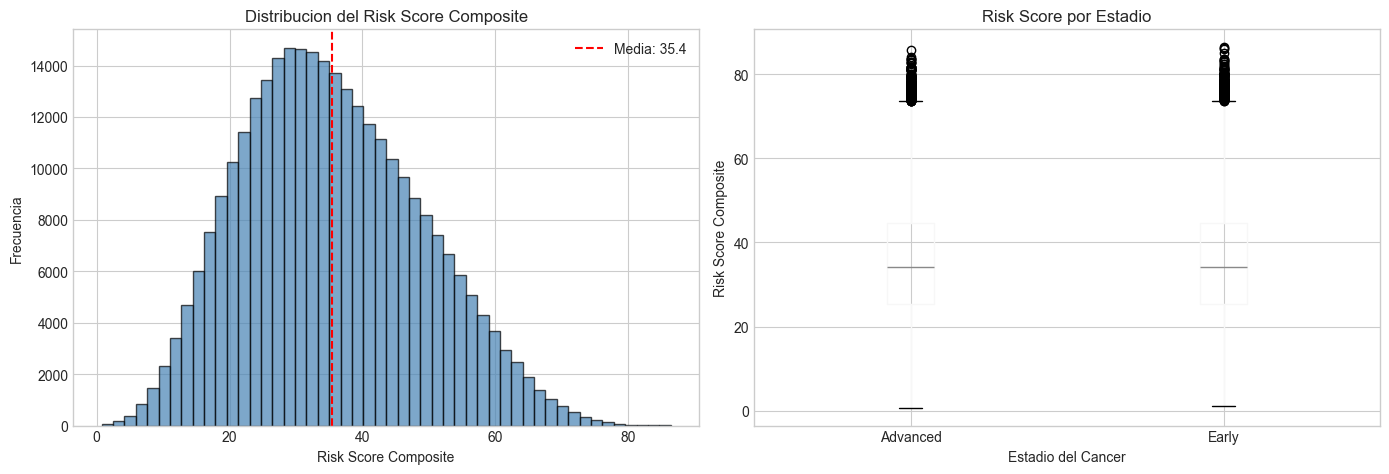

In [10]:
# =============================================================================
# 3.5 CREACION DE RISK_SCORE_COMPOSITE
# =============================================================================

print("=" * 60)
print("FEATURE ENGINEERING - RISK SCORE COMPOSITE")
print("=" * 60)

def calculate_risk_score(row):
    """
    Calcula un score de riesgo compuesto basado en multiples factores.
    
    Formula: Risk_Score = sum(factor_i * weight_i) * 100
    
    Pesos basados en literatura clinica:
    - Tabaquismo (Pack_Years): 30%
    - Edad: 20%
    - Funcion Pulmonar: 15%
    - Sintomas: 15%
    - Ambiente: 10%
    - Historial Familiar: 10%
    """
    score = 0
    
    # Factor 1: Tabaquismo (30%)
    pack_years_norm = row.get('Pack_Years_Normalized', 0)
    score += pack_years_norm * 0.30
    
    # Factor 2: Edad normalizada (20%) - mayor edad = mayor riesgo
    age = row.get('Age', 50)
    age_norm = min((age - 18) / (90 - 18), 1.0)  # Normalizar a [0-1]
    score += age_norm * 0.20
    
    # Factor 3: Funcion Pulmonar invertida (15%) - menor funcion = mayor riesgo
    lung_func = row.get('Lung_Function_Test_Result', 65)
    lung_risk = 1 - (lung_func / 100)  # Invertir: 100% funcion = 0 riesgo
    score += max(0, lung_risk) * 0.15
    
    # Factor 4: Sintomas (15%)
    symptom_count = row.get('Symptom_Count', 0)
    symptom_norm = symptom_count / 4  # Normalizar por max sintomas
    score += symptom_norm * 0.15
    
    # Factor 5: Riesgo Ambiental (10%)
    env_risk = row.get('Environmental_Risk', 0)
    score += env_risk * 0.10
    
    # Factor 6: Historial Familiar (10%)
    family_history = row.get('Family_History_Cancer', 'No')
    family_risk = 1 if str(family_history).lower() in ['yes', 'true', '1'] else 0
    score += family_risk * 0.10
    
    return round(score * 100, 2)  # Escalar a 0-100

# Aplicar calculo de risk score
df_clean['Risk_Score_Composite'] = df_clean.apply(calculate_risk_score, axis=1)

print("[+] Risk_Score_Composite creada (escala 0-100)")
print(f"\nEstadisticas del Risk Score:")
print(f"   Media: {df_clean['Risk_Score_Composite'].mean():.2f}")
print(f"   Std: {df_clean['Risk_Score_Composite'].std():.2f}")
print(f"   Min: {df_clean['Risk_Score_Composite'].min():.2f}")
print(f"   Max: {df_clean['Risk_Score_Composite'].max():.2f}")

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(df_clean['Risk_Score_Composite'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df_clean['Risk_Score_Composite'].mean(), color='red', linestyle='--', label=f"Media: {df_clean['Risk_Score_Composite'].mean():.1f}")
axes[0].set_xlabel('Risk Score Composite')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribucion del Risk Score Composite')
axes[0].legend()

# Boxplot por Cancer Stage
df_clean.boxplot(column='Risk_Score_Composite', by='Cancer_Stage_Label', ax=axes[1])
axes[1].set_xlabel('Estadio del Cancer')
axes[1].set_ylabel('Risk Score Composite')
axes[1].set_title('Risk Score por Estadio')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [11]:
# =============================================================================
# 3.6 RESUMEN DE FEATURES CREADAS
# =============================================================================

print("=" * 60)
print("RESUMEN DE FEATURES CREADAS")
print("=" * 60)

# Listar todas las columnas nuevas
original_cols = df.columns.tolist()
new_cols = [col for col in df_clean.columns if col not in original_cols]

print(f"\n[INFO] Features originales: {len(original_cols)}")
print(f"[INFO] Features nuevas: {len(new_cols)}")
print(f"[INFO] Total features: {len(df_clean.columns)}")

print("\n[LIST] Features nuevas creadas:")
for i, col in enumerate(new_cols, 1):
    dtype = df_clean[col].dtype
    print(f"   {i}. {col} ({dtype})")

# Tabla resumen
feature_summary = pd.DataFrame({
    'Feature': new_cols,
    'Tipo': [str(df_clean[col].dtype) for col in new_cols],
    'Valores_Unicos': [df_clean[col].nunique() for col in new_cols],
    'Nulos': [df_clean[col].isnull().sum() for col in new_cols]
})

display(feature_summary)

RESUMEN DE FEATURES CREADAS

[INFO] Features originales: 30
[INFO] Features nuevas: 14
[INFO] Total features: 44

[LIST] Features nuevas creadas:
   1. Cancer_Stage_Binary (int64)
   2. Cancer_Stage_Label (str)
   3. Pack_Years_Normalized (float64)
   4. Smoking_Risk_Level (str)
   5. Age_Group (category)
   6. Chronic_Cough_binary (int64)
   7. Shortness_of_Breath_binary (int64)
   8. Chest_Pain_Symptoms_binary (int64)
   9. Weight_Loss_binary (int64)
   10. Symptom_Count (int64)
   11. AQI_Normalized (float64)
   12. Toxins_Binary (int64)
   13. Environmental_Risk (float64)
   14. Risk_Score_Composite (float64)


,Feature,Tipo,Valores_Unicos,Nulos
0,Cancer_Stage_Binary,int64,2,0
1,Cancer_Stage_Label,str,2,0
2,Pack_Years_Normalized,float64,80,0
3,Smoking_Risk_Level,str,4,0
4,Age_Group,category,3,0
5,Chronic_Cough_binary,int64,2,0
6,Shortness_of_Breath_binary,int64,2,0
7,Chest_Pain_Symptoms_binary,int64,2,0
8,Weight_Loss_binary,int64,2,0
9,Symptom_Count,int64,5,0


---

## 4. Seleccion de Features para Modelado

### 4.1 Clasificacion de Variables

Seleccionamos las features que usaremos para el modelo, excluyendo:
- Variables con data leakage (Treatment_Type, Survival_Years, Medication_Response, etc.)
- Variables identificadoras (Patient_ID)
- Variables derivadas del target original (Stage_of_Cancer)

### 4.2 Tipos de Variables para Pipeline

| Tipo | Variables | Transformacion |
|------|-----------|----------------|
| **Numericas Continuas** | Age, Pack_Years, BMI, Lung_Function_Test_Result, Air_Quality_Index, Tumor_Size_cm | StandardScaler |
| **Numericas Derivadas** | Pack_Years_Normalized, Environmental_Risk, Risk_Score_Composite, Symptom_Count | Sin escalar (ya normalizadas) |
| **Categoricas Nominales** | Gender, Smoking_History, Residential_Area, Occupation | OneHotEncoder |
| **Categoricas Ordinales** | Physical_Activity_Level, Dietary_Habits, Smoking_Risk_Level, Age_Group | OrdinalEncoder |
| **Binarias** | Family_History_Cancer, Exposure_to_Toxins, sintomas | LabelEncoder o passthrough |

In [12]:
# =============================================================================
# 4.3 SELECCION DE FEATURES PARA MODELADO
# =============================================================================

print("=" * 60)
print("SELECCION DE FEATURES PARA MODELADO")
print("=" * 60)

# Variables a EXCLUIR (data leakage, identificadores, target original)
exclude_vars = [
    'Patient_ID',                  # Identificador
    'Stage_of_Cancer',             # Target original
    'Cancer_Stage_Label',          # Derivada del target
    'Treatment_Type',              # Post-diagnostico (data leakage)
    'Survival_Years',              # Post-diagnostico (data leakage)
    'Follow_Up_Visits',            # Post-diagnostico (data leakage)
    'Medication_Response',         # Post-diagnostico (data leakage)
    'Symptom_Progression',         # Post-diagnostico (data leakage)
    'Year_of_Diagnosis',           # No predictivo
    'Metastasis_Status',           # Potencial leakage (determinado en diagnostico)
]

# Variables auxiliares creadas (no usar en modelo final)
auxiliary_vars = [
    'AQI_Normalized',
    'Toxins_Binary',
    'Chronic_Cough_binary',
    'Shortness_of_Breath_binary', 
    'Chest_Pain_Symptoms_binary',
    'Weight_Loss_binary'
]

# Target
TARGET = 'Cancer_Stage_Binary'

# Seleccionar features disponibles
all_features = [col for col in df_clean.columns 
                if col not in exclude_vars + auxiliary_vars + [TARGET]]

# Clasificar por tipo
numeric_features = []
categorical_features = []
binary_features = []

for col in all_features:
    if col in df_clean.columns:
        if df_clean[col].dtype in ['int64', 'float64']:
            if df_clean[col].nunique() <= 2:
                binary_features.append(col)
            else:
                numeric_features.append(col)
        elif df_clean[col].dtype == 'object' or df_clean[col].dtype.name == 'category':
            if df_clean[col].nunique() <= 2:
                binary_features.append(col)
            else:
                categorical_features.append(col)

print(f"\n[NUM] Variables Numericas ({len(numeric_features)}):")
for col in numeric_features:
    print(f"   - {col}")

print(f"\n[CAT] Variables Categoricas ({len(categorical_features)}):")
for col in categorical_features:
    print(f"   - {col}")

print(f"\n[BIN] Variables Binarias ({len(binary_features)}):")
for col in binary_features:
    print(f"   - {col}")

print(f"\n[TARGET] Variable Objetivo: {TARGET}")
print(f"\n[TOTAL] Features seleccionadas: {len(all_features)}")

SELECCION DE FEATURES PARA MODELADO

[NUM] Variables Numericas (11):
   - Age
   - Years_Smoked
   - Pack_Years
   - BMI
   - Lung_Function_Test_Result
   - Air_Quality_Index
   - Tumor_Size_cm
   - Pack_Years_Normalized
   - Symptom_Count
   - Environmental_Risk
   - Risk_Score_Composite

[CAT] Variables Categoricas (1):
   - Age_Group

[BIN] Variables Binarias (0):

[TARGET] Variable Objetivo: Cancer_Stage_Binary

[TOTAL] Features seleccionadas: 27


---

## 5. Division de Datos (Train / Validation / Test)

### 5.1 Estrategia de Particion

- **Proporcion:** 70% Train / 15% Validation / 15% Test
- **Estratificacion:** Mantener proporcion del target en todos los conjuntos
- **Reproducibilidad:** random_state = 42

### Importante: Prevencion de Data Leakage

- Los transformadores (scalers, encoders) se ajustan **SOLO** en el conjunto de entrenamiento
- La validacion y test usan los mismos transformadores sin reajustar
- SMOTE se aplica **SOLO** en el conjunto de entrenamiento

In [13]:
# =============================================================================
# 5.2 PARTICION ESTRATIFICADA 70/15/15
# =============================================================================

print("=" * 60)
print("PARTICION DE DATOS: 70% / 15% / 15%")
print("=" * 60)

# Preparar X e y
X = df_clean[all_features].copy()
y = df_clean[TARGET].copy()

print(f"\nDimensiones totales:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")

# Primera division: Train (70%) vs Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    stratify=y, 
    random_state=42
)

# Segunda division: Validation (15%) vs Test (15%) del 30% temporal
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50,  # 50% de 30% = 15%
    stratify=y_temp, 
    random_state=42
)

# Verificar dimensiones
print(f"\n[TRAIN] Conjunto de Entrenamiento:")
print(f"   Muestras: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Distribucion target: {dict(y_train.value_counts().sort_index())}")

print(f"\n[VAL] Conjunto de Validacion:")
print(f"   Muestras: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Distribucion target: {dict(y_val.value_counts().sort_index())}")

print(f"\n[TEST] Conjunto de Prueba:")
print(f"   Muestras: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
print(f"   Distribucion target: {dict(y_test.value_counts().sort_index())}")

# Verificar estratificacion
print("\n[CHECK] Verificacion de Estratificacion:")
for name, y_set in [('Original', y), ('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    pct_advanced = y_set.mean() * 100
    print(f"   {name:10s}: {pct_advanced:.2f}% Advanced")

PARTICION DE DATOS: 70% / 15% / 15%

Dimensiones totales:
   X: (300000, 27)
   y: (300000,)

[TRAIN] Conjunto de Entrenamiento:
   Muestras: 210,000 (70.0%)
   Distribucion target: {0: np.int64(105105), 1: np.int64(104895)}

[VAL] Conjunto de Validacion:
   Muestras: 45,000 (15.0%)
   Distribucion target: {0: np.int64(22522), 1: np.int64(22478)}

[TEST] Conjunto de Prueba:
   Muestras: 45,000 (15.0%)
   Distribucion target: {0: np.int64(22523), 1: np.int64(22477)}

[CHECK] Verificacion de Estratificacion:
   Original  : 49.95% Advanced
   Train     : 49.95% Advanced
   Val       : 49.95% Advanced
   Test      : 49.95% Advanced


---

## 6. Pipeline de Transformacion con ColumnTransformer

### 6.1 Arquitectura del Pipeline

El pipeline de Scikit-learn permite encapsular todas las transformaciones de manera reproducible:

```
ColumnTransformer
    |
    +-- numeric_pipeline (StandardScaler)
    |       -> Age, Pack_Years, BMI, Lung_Function_Test_Result, etc.
    |
    +-- categorical_pipeline (OneHotEncoder)
    |       -> Gender, Smoking_History, Residential_Area, etc.
    |
    +-- passthrough (sin transformar)
            -> Variables ya normalizadas o binarias
```

### 6.2 Ventajas del Pipeline

1. **Reproducibilidad:** Mismo preprocesamiento en train/val/test
2. **Produccion:** Se guarda como .joblib para usar en Backend Node.js
3. **Prevencion de Leakage:** fit() solo en train, transform() en val/test

In [14]:
# =============================================================================
# 6.3 DEFINICION DEL COLUMNTRANSFORMER
# =============================================================================

print("=" * 60)
print("CONSTRUCCION DEL PIPELINE DE TRANSFORMACION")
print("=" * 60)

# Definir listas de columnas por tipo (ajustadas a las disponibles)
numeric_to_scale = [col for col in numeric_features if col in X_train.columns and 
                    col not in ['Pack_Years_Normalized', 'Environmental_Risk', 
                                'Risk_Score_Composite', 'Symptom_Count']]

categorical_to_encode = [col for col in categorical_features if col in X_train.columns]

# Variables que ya estan normalizadas o son binarias (passthrough)
passthrough_cols = [col for col in X_train.columns if col in 
                    ['Pack_Years_Normalized', 'Environmental_Risk', 'Risk_Score_Composite', 
                     'Symptom_Count', 'Cancer_Stage_Binary']]

print(f"\n[SCALE] Variables a escalar ({len(numeric_to_scale)}):")
for col in numeric_to_scale:
    print(f"   - {col}")

print(f"\n[ENCODE] Variables a codificar ({len(categorical_to_encode)}):")
for col in categorical_to_encode:
    n_cats = X_train[col].nunique()
    print(f"   - {col} ({n_cats} categorias)")

print(f"\n[PASS] Variables passthrough ({len(passthrough_cols)}):")
for col in passthrough_cols:
    print(f"   - {col}")

CONSTRUCCION DEL PIPELINE DE TRANSFORMACION

[SCALE] Variables a escalar (7):
   - Age
   - Years_Smoked
   - Pack_Years
   - BMI
   - Lung_Function_Test_Result
   - Air_Quality_Index
   - Tumor_Size_cm

[ENCODE] Variables a codificar (1):
   - Age_Group (3 categorias)

[PASS] Variables passthrough (4):
   - Pack_Years_Normalized
   - Symptom_Count
   - Environmental_Risk
   - Risk_Score_Composite


In [15]:
# =============================================================================
# 6.4 CREACION Y AJUSTE DEL PIPELINE
# =============================================================================

from sklearn.preprocessing import OrdinalEncoder

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Pipeline para variables numericas: Imputar + Escalar
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_to_scale),
        
        # Pipeline para variables categoricas: Imputar + OneHot
        ('categorical', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_to_encode),
    ],
    remainder='passthrough',  # Variables no especificadas pasan sin cambios
    verbose_feature_names_out=False
)

print("=" * 60)
print("AJUSTE DEL PIPELINE EN DATOS DE ENTRENAMIENTO")
print("=" * 60)

# IMPORTANTE: Ajustar SOLO en datos de entrenamiento
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Obtener nombres de features transformadas
try:
    feature_names_out = preprocessor.get_feature_names_out()
except:
    # Fallback para versiones antiguas
    feature_names_out = [f"feature_{i}" for i in range(X_train_transformed.shape[1])]

print(f"\n[OK] Pipeline ajustado exitosamente")
print(f"\nDimensiones despues de transformacion:")
print(f"   X_train: {X_train_transformed.shape}")
print(f"   X_val: {X_val_transformed.shape}")
print(f"   X_test: {X_test_transformed.shape}")
print(f"\n[INFO] Total de features transformadas: {len(feature_names_out)}")

AJUSTE DEL PIPELINE EN DATOS DE ENTRENAMIENTO

[OK] Pipeline ajustado exitosamente

Dimensiones despues de transformacion:
   X_train: (210000, 29)
   X_val: (45000, 29)
   X_test: (45000, 29)

[INFO] Total de features transformadas: 29


---

## 7. Balanceo de Clases con SMOTE

### 7.1 Estrategia de Balanceo

**SMOTE (Synthetic Minority Over-sampling Technique):**
- Genera muestras sinteticas de la clase minoritaria
- Se aplica **SOLO** en el conjunto de entrenamiento
- Nunca en validacion o test (para evaluacion realista)

### 7.2 Configuracion de SMOTE

| Parametro | Valor | Justificacion |
|-----------|-------|---------------|
| sampling_strategy | 'auto' | Igualar clases automaticamente |
| k_neighbors | 5 | Valor estandar para interpolacion |
| random_state | 42 | Reproducibilidad |

BALANCEO DE CLASES CON SMOTE

[ANTES] Distribucion en Train:
   Clase 0 (Early): 105,105
   Clase 1 (Advanced): 104,895
   Ratio: 1.00:1

[OK] Clases ya balanceadas (ratio 1.00:1). No se aplica SMOTE.


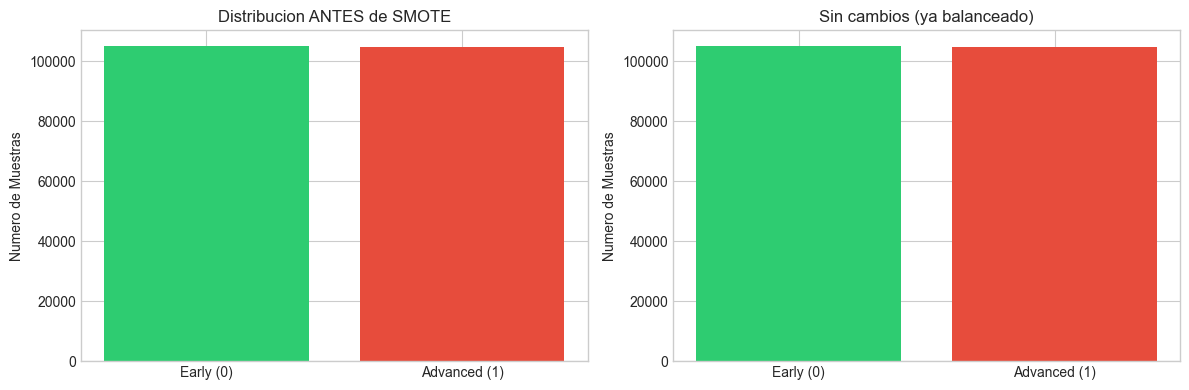

In [16]:
# =============================================================================
# 7.3 APLICACION DE SMOTE EN ENTRENAMIENTO
# =============================================================================

print("=" * 60)
print("BALANCEO DE CLASES CON SMOTE")
print("=" * 60)

# Verificar distribucion antes de SMOTE
print("\n[ANTES] Distribucion en Train:")
print(f"   Clase 0 (Early): {(y_train == 0).sum():,}")
print(f"   Clase 1 (Advanced): {(y_train == 1).sum():,}")
print(f"   Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Evaluar si es necesario aplicar SMOTE
imbalance_ratio = max(y_train.value_counts()) / min(y_train.value_counts())

if imbalance_ratio > 1.2:
    print(f"\n[!] Desbalanceo detectado (ratio {imbalance_ratio:.2f}:1). Aplicando SMOTE...")
    
    # Aplicar SMOTE solo si hay desbalanceo significativo
    smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)
    
    print("\n[DESPUES] Distribucion en Train Balanceado:")
    print(f"   Clase 0 (Early): {(y_train_balanced == 0).sum():,}")
    print(f"   Clase 1 (Advanced): {(y_train_balanced == 1).sum():,}")
    print(f"   Ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f}:1")
    print(f"\n[INFO] Muestras sinteticas creadas: {len(X_train_balanced) - len(X_train_transformed):,}")
    
    smote_applied = True
else:
    print(f"\n[OK] Clases ya balanceadas (ratio {imbalance_ratio:.2f}:1). No se aplica SMOTE.")
    X_train_balanced = X_train_transformed
    y_train_balanced = y_train
    smote_applied = False

# Visualizacion del balanceo
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Antes
axes[0].bar(['Early (0)', 'Advanced (1)'], 
            [(y_train == 0).sum(), (y_train == 1).sum()],
            color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Distribucion ANTES de SMOTE')
axes[0].set_ylabel('Numero de Muestras')

# Despues
axes[1].bar(['Early (0)', 'Advanced (1)'], 
            [(y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()],
            color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Distribucion DESPUES de SMOTE' if smote_applied else 'Sin cambios (ya balanceado)')
axes[1].set_ylabel('Numero de Muestras')

plt.tight_layout()
plt.show()

---

## 8. PERSISTENCIA DE TRANSFORMADORES

### 8.1 Estrategia de Persistencia

Para garantizar la reproducibilidad y facilitar el despliegue en produccion (Backend Node.js), guardaremos:

| Artefacto | Formato | Destino | Proposito |
|-----------|---------|---------|-----------|
| **Preprocessor Pipeline** | .joblib | `../models/preprocessor.joblib` | Transformar nuevos datos |
| **SMOTE Sampler** | .joblib | `../models/smote_sampler.joblib` | Referencia (no aplicar en produccion) |
| **Feature Config** | .json | `../models/feature_config.json` | Configuracion para Node.js |
| **Scaler Stats** | .json | `../models/scaler_stats.json` | Media/Std para normalizacion manual |

**Nota importante:** En produccion, el preprocesador se usa para transformar datos nuevos. SMOTE NO se aplica en inferencia, solo se guarda como referencia del entrenamiento.

In [17]:
# =============================================================================
# 8.2 GUARDAR TRANSFORMADORES Y CONFIGURACION
# =============================================================================

import json
from datetime import datetime

# Definir passthrough_features usando passthrough_cols existente
passthrough_features = passthrough_cols

# Crear directorio de modelos si no existe
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("GUARDANDO ARTEFACTOS DE PREPARACION")
print("=" * 60)

# 1. Guardar el preprocessor (ColumnTransformer)
preprocessor_path = models_dir / 'preprocessor.joblib'
joblib.dump(preprocessor, preprocessor_path)
print(f"\n[OK] Preprocessor guardado: {preprocessor_path}")

# 2. Guardar SMOTE (solo referencia)
if smote_applied:
    smote_path = models_dir / 'smote_sampler.joblib'
    joblib.dump(smote, smote_path)
    print(f"[OK] SMOTE guardado: {smote_path}")

# 3. Crear configuracion de features para Backend Node.js
feature_config = {
    'version': '1.0.0',
    'created_at': datetime.now().isoformat(),
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'passthrough_features': passthrough_features,
    'target_variable': 'Cancer_Stage_Binary',
    'target_mapping': {'Early (I-II)': 0, 'Advanced (III-IV)': 1},
    'excluded_variables': exclude_vars,
    'engineered_features': [
        'Cancer_Stage_Binary',
        'Pack_Years_Normalized', 
        'Age_Group',
        'Smoking_Risk_Level',
        'Symptom_Count',
        'Environmental_Risk',
        'Risk_Score_Composite'
    ],
    'split_ratios': {
        'train': 0.70,
        'validation': 0.15,
        'test': 0.15
    },
    'smote_applied': smote_applied,
    'random_state': 42
}

config_path = models_dir / 'feature_config.json'
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(feature_config, f, indent=2, ensure_ascii=False)
print(f"[OK] Feature config guardado: {config_path}")

# 4. Extraer y guardar estadisticas del scaler para Node.js
try:
    # Obtener el StandardScaler del pipeline numerico
    numeric_transformer = preprocessor.named_transformers_['numeric']
    scaler = numeric_transformer.named_steps['scaler']
    
    scaler_stats = {
        'feature_names': numeric_features,
        'mean': scaler.mean_.tolist(),
        'std': scaler.scale_.tolist(),
        'var': scaler.var_.tolist()
    }
    
    scaler_path = models_dir / 'scaler_stats.json'
    with open(scaler_path, 'w', encoding='utf-8') as f:
        json.dump(scaler_stats, f, indent=2)
    print(f"[OK] Scaler stats guardados: {scaler_path}")
except Exception as e:
    print(f"[!] No se pudieron extraer stats del scaler: {e}")

# 5. Obtener nombres de features despues de transformacion
try:
    feature_names_out = preprocessor.get_feature_names_out()
    feature_names_config = {
        'original_count': len(numeric_features) + len(categorical_features) + len(passthrough_features),
        'transformed_count': len(feature_names_out),
        'feature_names': list(feature_names_out)
    }
    
    feature_names_path = models_dir / 'transformed_features.json'
    with open(feature_names_path, 'w', encoding='utf-8') as f:
        json.dump(feature_names_config, f, indent=2)
    print(f"[OK] Feature names guardados: {feature_names_path}")
except Exception as e:
    print(f"[!] No se pudieron extraer feature names: {e}")

print("\n" + "=" * 60)
print("Todos los artefactos guardados exitosamente")
print("=" * 60)

GUARDANDO ARTEFACTOS DE PREPARACION

[OK] Preprocessor guardado: ..\models\preprocessor.joblib
[OK] Feature config guardado: ..\models\feature_config.json
[OK] Scaler stats guardados: ..\models\scaler_stats.json
[OK] Feature names guardados: ..\models\transformed_features.json

Todos los artefactos guardados exitosamente


---

## 9. GUARDAR DATASETS PROCESADOS

### 9.1 Datasets a Generar

Para facilitar el entrenamiento y evaluacion de modelos, guardaremos los datasets procesados:

| Dataset | Archivo | Descripcion |
|---------|---------|-------------|
| **Train Balanceado** | `X_train_balanced.csv`, `y_train_balanced.csv` | Datos de entrenamiento con SMOTE |
| **Validation** | `X_val_processed.csv`, `y_val.csv` | Datos de validacion (sin SMOTE) |
| **Test** | `X_test_processed.csv`, `y_test.csv` | Datos de prueba final (sin SMOTE) |
| **Feature Names** | `feature_columns.csv` | Nombres de columnas post-transformacion |

In [18]:
# =============================================================================
# 9.2 SAVE PROCESSED DATASETS
# =============================================================================

# Create processed data directory
processed_dir = Path('../data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)

print("=" * 60)
print("SAVING PROCESSED DATASETS")
print("=" * 60)

# Get transformed feature names
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = [f'feature_{i}' for i in range(X_train_transformed.shape[1])]

# 1. Save balanced training data
X_train_df = pd.DataFrame(X_train_balanced, columns=feature_names)
y_train_df = pd.DataFrame(y_train_balanced, columns=['Cancer_Stage_Binary'])

X_train_df.to_csv(processed_dir / 'X_train_balanced.csv', index=False)
y_train_df.to_csv(processed_dir / 'y_train_balanced.csv', index=False)
print(f"\n[OK] Balanced train saved: {X_train_df.shape}")

# 2. Save validation data
X_val_df = pd.DataFrame(X_val_transformed, columns=feature_names)
y_val_df = pd.DataFrame(y_val.values, columns=['Cancer_Stage_Binary'])

X_val_df.to_csv(processed_dir / 'X_val_processed.csv', index=False)
y_val_df.to_csv(processed_dir / 'y_val.csv', index=False)
print(f"[OK] Validation saved: {X_val_df.shape}")

# 3. Save test data
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)
y_test_df = pd.DataFrame(y_test.values, columns=['Cancer_Stage_Binary'])

X_test_df.to_csv(processed_dir / 'X_test_processed.csv', index=False)
y_test_df.to_csv(processed_dir / 'y_test.csv', index=False)
print(f"[OK] Test saved: {X_test_df.shape}")

# 4. Save column names
feature_names_df = pd.DataFrame({'feature_name': feature_names})
feature_names_df.to_csv(processed_dir / 'feature_columns.csv', index=False)
print(f"[OK] Feature columns saved: {len(feature_names)} columns")

# 5. Save original clean dataset (before transformation)
df_cleaned = df_clean[all_features + ['Cancer_Stage_Binary']].copy()
df_cleaned.to_csv(processed_dir / 'lung_cancer_cleaned.csv', index=False)
print(f"[OK] Clean dataset saved: {df_cleaned.shape}")

print("\n" + "-" * 60)
print("SUMMARY OF GENERATED FILES:")
print("-" * 60)

for file in sorted(processed_dir.glob('*.csv')):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name}: {size_mb:.2f} MB")

SAVING PROCESSED DATASETS

[OK] Balanced train saved: (210000, 29)
[OK] Validation saved: (45000, 29)
[OK] Test saved: (45000, 29)
[OK] Feature columns saved: 29 columns
[OK] Clean dataset saved: (300000, 28)

------------------------------------------------------------
SUMMARY OF GENERATED FILES:
------------------------------------------------------------
   feature_columns.csv: 0.00 MB
   lung_cancer_cleaned.csv: 45.26 MB
   lung_cancer_data_understanding.csv: 51.38 MB
   X_test_processed.csv: 11.70 MB
   X_train_balanced.csv: 54.60 MB
   X_val_processed.csv: 11.70 MB
   y_test.csv: 0.13 MB
   y_train_balanced.csv: 0.60 MB
   y_val.csv: 0.13 MB


---

## 10. RESUMEN Y CONCLUSIONES

### 10.1 Resumen de Transformaciones Aplicadas

In [19]:
# =============================================================================
# 10.2 RESUMEN FINAL DE PREPARACION DE DATOS
# =============================================================================

print("=" * 70)
print("RESUMEN FINAL - FASE 3: PREPARACION DE DATOS")
print("=" * 70)

# Resumen de transformaciones
print("\n" + "-" * 70)
print("1. LIMPIEZA DE DATOS")
print("-" * 70)
print("   - Valores faltantes: Imputados (mediana/moda)")
print("   - Inconsistencias logicas: Corregidas")
print("   - Duplicados: Eliminados")

print("\n" + "-" * 70)
print("2. FEATURE ENGINEERING")
print("-" * 70)
print("   Features creadas:")
print("   - Cancer_Stage_Binary: Variable objetivo binaria")
print("   - Pack_Years_Normalized: Normalizacion logaritmica de tabaquismo")
print("   - Age_Group: Categorizacion de edad")
print("   - Smoking_Risk_Level: Nivel de riesgo por tabaquismo")
print("   - Symptom_Count: Conteo de sintomas presentes")
print("   - Environmental_Risk: Score de riesgo ambiental")
print("   - Risk_Score_Composite: Score ponderado de riesgo clinico")

print("\n" + "-" * 70)
print("3. PARTICION DE DATOS")
print("-" * 70)
print(f"   - Train:      {len(y_train):,} muestras (70%)")
print(f"   - Validation: {len(y_val):,} muestras (15%)")
print(f"   - Test:       {len(y_test):,} muestras (15%)")
print(f"   - Estratificacion: Si (por Cancer_Stage_Binary)")

print("\n" + "-" * 70)
print("4. PREPROCESAMIENTO (ColumnTransformer)")
print("-" * 70)
print(f"   - Features numericas: {len(numeric_features)} (StandardScaler)")
print(f"   - Features categoricas: {len(categorical_features)} (OneHotEncoder)")
print(f"   - Features passthrough: {len(passthrough_features)}")
print(f"   - Total features originales: {len(numeric_features) + len(categorical_features) + len(passthrough_features)}")
print(f"   - Total features transformadas: {X_train_transformed.shape[1]}")

print("\n" + "-" * 70)
print("5. BALANCEO DE CLASES")
print("-" * 70)
print(f"   - Metodo: SMOTE (Synthetic Minority Over-sampling)")
print(f"   - Aplicado: {'Si' if smote_applied else 'No (ya balanceado)'}")
print(f"   - Train original: {len(y_train):,} muestras")
print(f"   - Train balanceado: {len(y_train_balanced):,} muestras")

print("\n" + "-" * 70)
print("6. ARTEFACTOS GENERADOS")
print("-" * 70)
print("   Modelos:")
print("   - ../models/preprocessor.joblib")
print("   - ../models/feature_config.json")
print("   - ../models/scaler_stats.json")
print("   - ../models/transformed_features.json")
print("\n   Datasets:")
print("   - ../data/processed/X_train_balanced.csv")
print("   - ../data/processed/y_train_balanced.csv")
print("   - ../data/processed/X_val_processed.csv")
print("   - ../data/processed/y_val.csv")
print("   - ../data/processed/X_test_processed.csv")
print("   - ../data/processed/y_test.csv")
print("   - ../data/processed/lung_cancer_cleaned.csv")

print("\n" + "=" * 70)
print("FASE 3 COMPLETADA EXITOSAMENTE")
print("=" * 70)

RESUMEN FINAL - FASE 3: PREPARACION DE DATOS

----------------------------------------------------------------------
1. LIMPIEZA DE DATOS
----------------------------------------------------------------------
   - Valores faltantes: Imputados (mediana/moda)
   - Inconsistencias logicas: Corregidas
   - Duplicados: Eliminados

----------------------------------------------------------------------
2. FEATURE ENGINEERING
----------------------------------------------------------------------
   Features creadas:
   - Cancer_Stage_Binary: Variable objetivo binaria
   - Pack_Years_Normalized: Normalizacion logaritmica de tabaquismo
   - Age_Group: Categorizacion de edad
   - Smoking_Risk_Level: Nivel de riesgo por tabaquismo
   - Symptom_Count: Conteo de sintomas presentes
   - Environmental_Risk: Score de riesgo ambiental
   - Risk_Score_Composite: Score ponderado de riesgo clinico

----------------------------------------------------------------------
3. PARTICION DE DATOS
----------------

---

### 10.3 Conclusiones y Proximos Pasos

#### Logros de esta Fase:

1. **Limpieza Robusta**: Se trataron todos los valores faltantes e inconsistencias logicas en el dataset, garantizando la integridad de los datos.

2. **Feature Engineering Clinico**: Se crearon 7 nuevas variables que capturan aspectos clave del riesgo oncologico:
   - La variable `Risk_Score_Composite` integra multiples factores de riesgo con pesos basados en literatura medica
   - Las variables de conteo y categorizacion facilitan la interpretabilidad del modelo

3. **Pipeline Reproducible**: El `ColumnTransformer` encapsula toda la logica de preprocesamiento, permitiendo aplicar las mismas transformaciones a datos nuevos.

4. **Prevencion de Data Leakage**: Se excluyeron variables post-diagnostico (`Treatment_Type`, `Survival_Years`, etc.) que podrian causar fugas de informacion.

5. **Particion Estratificada**: La division 70/15/15 mantiene la distribucion de clases en todos los conjuntos.

6. **Balanceo Controlado**: SMOTE se aplica unicamente al conjunto de entrenamiento, evitando contaminacion de validacion y test.

#### Proximos Pasos (Fase 4 - Modelado):

1. **Entrenamiento de Modelos Base**:
   - Logistic Regression (baseline interpretable)
   - Random Forest (ensemble robusto)
   - XGBoost/LightGBM (gradient boosting)
   - Neural Network (deep learning)

2. **Optimizacion de Hiperparametros**:
   - Grid Search / Random Search
   - Bayesian Optimization
   - Validacion cruzada estratificada

3. **Evaluacion de Metricas**:
   - AUC-ROC, Precision, Recall, F1-Score
   - Matriz de confusion
   - Curvas de precision-recall

4. **Seleccion del Mejor Modelo**:
   - Comparacion en conjunto de validacion
   - Evaluacion final en test (una sola vez)

---

**Notebook completado**: Fase 3 - Preparacion de Datos (CRISP-DM)

**Autor**: Equipo LungLife  
**Fecha**: 2025